In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.625 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 30000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

300000000.0


In [7]:
Eb

array([9.99999999e-05, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

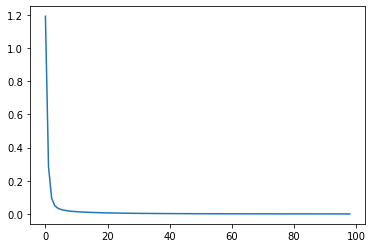

In [8]:
plt.plot(S)

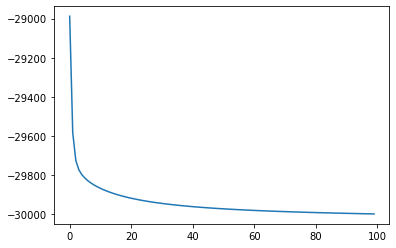

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0006151665783836507

In [11]:
eta

array([-28988.07587985, -29584.06154497, -29726.32011371, -29774.29590721,
       -29799.48542836, -29816.95903941, -29830.67164023, -29842.11221801,
       -29851.9936213 , -29860.7149832 , -29868.52545826, -29875.59341049,
       -29882.03960248, -29887.95471437, -29893.40931297, -29898.45988176,
       -29903.15265805, -29907.52618223, -29911.61305511, -29915.44118892,
       -29919.03472301, -29922.4147109 , -29925.59964677, -29928.60587686,
       -29931.44792608, -29934.13876128, -29936.69000618, -29939.11211881,
       -29941.41453952, -29943.60581546, -29945.69370625, -29947.68527418,
       -29949.58696173, -29951.40465861, -29953.14375996, -29954.8092172 ,
       -29956.40558252, -29957.93704813, -29959.40748078, -29960.82045247,
       -29962.17926761, -29963.4869873 , -29964.74645094, -29965.96029568,
       -29967.13097374, -29968.2607681 , -29969.35180654, -29970.40607438,
       -29971.42542599, -29972.41159517, -29973.36620461, -29974.29077449,
       -29975.18673026, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.01132413e+03, 4.15338461e+02, 2.73079892e+02, 2.25104098e+02,
       1.99914577e+02, 1.82440966e+02, 1.68728365e+02, 1.57287788e+02,
       1.47406384e+02, 1.38685022e+02, 1.30874547e+02, 1.23806595e+02,
       1.17360403e+02, 1.11445291e+02, 1.05990693e+02, 1.00940124e+02,
       9.62473476e+01, 9.18738234e+01, 8.77869505e+01, 8.39588167e+01,
       8.03652826e+01, 7.69852948e+01, 7.38003589e+01, 7.07941288e+01,
       6.79520796e+01, 6.52612444e+01, 6.27099995e+01, 6.02878868e+01,
       5.79854661e+01, 5.57941902e+01, 5.37062994e+01, 5.17147315e+01,
       4.98130439e+01, 4.79953470e+01, 4.62562457e+01, 4.45907885e+01,
       4.29944231e+01, 4.14629575e+01, 3.99925249e+01, 3.85795532e+01,
       3.72207380e+01, 3.59130184e+01, 3.46535547e+01, 3.34397100e+01,
       3.22690319e+01, 3.11392376e+01, 3.00481991e+01, 2.89939313e+01,
       2.79745797e+01, 2.69884105e+01, 2.60338010e+01, 2.51092312e+01,
       2.42132754e+01, 2.33445959e+01, 2.25019359e+01, 2.16841137e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_15.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_15.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_15.csv', S, delimiter = ',')